###### ScanNet

This notebook lets you instantiate the **[ScanNet](http://www.scan-net.org/)** dataset from scratch and visualize **3D+2D room samples**.

Note that you will need **at least 1.2T** available for the SanNet raw dataset and **at least 64G** for the processed files at **5cm voxel resolution** and **320x240 image resolution**. 

The ScanNet dataset is composed of **rooms** of video acquisitions of indoor scenes. Thes video streams were used to produce a point cloud and images.

Each room is small enough to be loaded at once into a **64G RAM** memory. The `ScannetDatasetMM` class from `torch_points3d.datasets.segmentation.multimodal.scannet` deals with loading the room and part of the images of the associated video stream.

In [1]:
# Select you GPU
I_GPU = 0

In [2]:
# Uncomment to use autoreload
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import torch
import numpy as np
from time import time
from omegaconf import OmegaConf
start = time()
import warnings
warnings.filterwarnings('ignore')

# torch.cuda.set_device(I_GPU)
DIR = os.path.dirname(os.getcwd())
ROOT = os.path.join(DIR, "..")
sys.path.insert(0, ROOT)
sys.path.insert(0, DIR)

from torch_points3d.utils.config import hydra_read
from torch_geometric.data import Data
from torch_points3d.core.multimodal.data import MMData, MMBatch
from torch_points3d.visualization.multimodal_data import visualize_mm_data
from torch_points3d.core.multimodal.image import SameSettingImageData, ImageData
from torch_points3d.datasets.segmentation.multimodal.scannet import ScannetDatasetMM
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS
from torch_points3d.metrics.segmentation_tracker import SegmentationTracker

from pykeops.torch import LazyTensor

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
MMData debug() function changed, please uncomment the 3rd assert line when doing inference without M2F features!


If `visualize_mm_data` does not throw any error but the visualization does not appear, you may need to change your plotly renderer below.

In [3]:
import plotly.io as pio

#pio.renderers.default = 'jupyterlab'        # for local notebook
pio.renderers.default = 'iframe_connected'  # for remote notebook. Other working (but seemingly slower) options are: 'sphinx_gallery' and 'iframe'

## Dataset creation

The following will instantiate the dataset. If the data is not found at `DATA_ROOT`, the folder structure will be created there and the raw dataset will be downloaded there. 

**Memory-friendly tip** : if you have already downloaded the dataset once and simply want to instantiate a new dataset with different preprocessing (*e.g* change 3D or 2D resolution, mapping parameterization, etc), I recommend you manually replicate the folder hierarchy of your already-existing dataset and create a symlink to its `raw/` directory to avoid downloading and storing (very) large files twice.

You will find the config file ruling the dataset creation at `conf/data/segmentation/multimodal/scannet-sparse.yaml`. You may edit this file or create new configs inheriting from this one using Hydra and create the associated dataset by modifying `dataset_config` accordingly in the following cell.

In [4]:
# Set your dataset root directory, where the data was/will be downloaded
DATA_ROOT = '/project/fsun/dvata'

dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-partial'   
models_config = 'segmentation/multimodal/Feng/mvfusion'    # model family
model_name = 'MVFusion'                       # specific model

overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'models={models_config}',
    f'model_name={model_name}',
    f'data.dataroot={DATA_ROOT}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
cfg.data.load_m2f_masks = True   # load Mask2Former predicted masks

The dataset will now be created based on the parsed configuration. I recommend having **at least 1.2T** available for the SanNet raw dataset and **at least 64G** for the processed files at **5cm voxel resolution** and **320x240 image resolution**. 

As long as you do not change core dataset parameters, preprocessing should only be performed once for your dataset. It may take some time, **mostly depending on the 3D and 2D resolutions** you choose to work with (the larger the slower).

In [5]:
# Dataset instantiation
start = time()
dataset = ScannetDatasetMM(cfg.data)
# print(dataset)|
print(f"Time = {time() - start:0.1f} sec.")

load_m2f_masks:  True
initialize train dataset
temporarily hard code N-views in get_view_dependent_features()
initialize val dataset
temporarily hard code N-views in get_view_dependent_features()
Time = 0.6 sec.


To visualize the multimodal samples produced by the dataset, we need to remove some of the dataset transforms that affect points, images and mappings. The `sample_real_data` function will be used to get samples without breaking mappings consistency for visualization.

At training and evaluation time, these transforms are used for data augmentation, dynamic size batching (see our [paper](https://arxiv.org/submit/4264152)), etc...

## Visualize a single multimodal sample

We can now pick samples from the train, val and test datasets.

Please refer to `torch_points3d/visualization/multimodal_data` for more details on visualization options.

In [6]:
# mm_data.modalities['image'][0].x.shape
# mm_data.modalities['image'][0].m2f_pred_mask.shape

In [7]:
# dataset.val_dataset[1]

In [8]:
# visualize_mm_data(mm_data, class_names=CLASS_NAMES, class_colors=CLASS_COLORS, error_color=(0, 0, 0), front='y', back='m2f_pred_mask', figsize=1000, pointsize=3, voxel=0.02, show_2d=True, alpha=0.3)


In [9]:
# # exact splatting
# i_room = 1

# # Pick a room in the Train set
# mm_data = sample_real_data(dataset.train_dataset, idx=i_room, exclude_3d=exclude_3d_viz, exclude_2d=exclude_2d_viz)

# # Pick a room in the Val set
# # mm_data = sample_real_data(dataset.val_dataset, idx=i_room, exclude_3d=exclude_3d_viz, exclude_2d=exclude_2d_viz)

# mm_data

# # 2.6422173976898193 previous for_1 loop
# # 3.252363681793213 for1 with random sample
# # 2.0284531116485596 for1 with numpy choice

In [10]:
def computeScores(data, preds, dataset, stage='train', tracker=None, reset=False):
    if len(preds.shape) < 2:
        preds = torch.nn.functional.one_hot(preds, num_classes=20)

    if tracker is None:
        tracker = SegmentationTracker(dataset, stage=stage, wandb_log=False, use_tensorboard=False, ignore_label=-1)
    
    if reset is True:
        tracker.reset()
    
    tracker._compute_metrics(outputs=preds, labels=data.data.y)
    
    return tracker.get_metrics()

In [11]:
# def get_m2f_features(data, n_views):
# #     n_views = 9

# #     ### Make a 3D point cloud populated by mode M2F labels!
# #     m2f_mapped_feats = data.modalities['image'].get_mapped_m2f_features(interpolate=True)[0]
# #     csr_idx = data.modalities['image'].view_cat_csr_indexing

# #     # Calculate amount of empty views. There should be n_points * n_views filled view conditions in total.
# #     n_seen = csr_idx[1:] - csr_idx[:-1]
# #     unfilled_points = n_seen[n_seen < n_views]
# #     n_views_to_fill = int(len(unfilled_points) * n_views - sum(unfilled_points))

# #     random_m2f_preds = m2f_mapped_feats[np.random.choice(range(len(m2f_mapped_feats)), size=n_views_to_fill, replace=True)]


# #     combined_m2f_tensor = torch.cat((m2f_mapped_feats, random_m2f_preds), dim=0)

# #     unused_invalid_view_idx = len(m2f_mapped_feats)
# #     combined_idx = []
# #     for i, n in enumerate(n_seen):
# #         if n < n_views:
# #             n_empty_views = n_views -  n
# #             combined_idx += list(range(csr_idx[i], csr_idx[i+1])) + \
# #                             list(range(unused_invalid_view_idx, unused_invalid_view_idx + n_empty_views))
# #             unused_invalid_view_idx += n_empty_views
# #         elif n > n_views:
# #             sampled_idx = sorted(np.random.choice(range(csr_idx[i], csr_idx[i+1]), size=n_views, replace=False))
# #             combined_idx += sampled_idx
# #         else:
# #             combined_idx += list(range(csr_idx[i], csr_idx[i+1]))

# #     # re-index tensor for MVFusion format
# #     combined_m2f_tensor = combined_m2f_tensor[combined_idx].reshape(data.num_points, n_views)
    
# #     return combined_m2f_tensor


#     pixel_validity = data.data.x[:, 0, 0]
#     print(pixel_validity, pixel_validity.shape)
    
    
#     # same for m2f feats
#     out = data.data.x
#     print(out, out.shape)

In [12]:
from torch_geometric.transforms import *
from torch_points3d.core.data_transform import *
from torch_points3d.core.data_transform.multimodal.image import *
from torch_points3d.datasets.base_dataset import BaseDataset
from torch_points3d.datasets.base_dataset_multimodal import BaseDatasetMM

# Transforms on 3D points that we need to exclude for visualization purposes
augmentations_3d = [
    ElasticDistortion, Random3AxisRotation, RandomNoise, RandomRotate, 
    RandomScaleAnisotropic, RandomSymmetry, ShiftVoxels]
exclude_3d_viz = augmentations_3d + [AddFeatsByKeys, Center, GridSampling3D]

# Transforms on 2D images and mappings that we need to exclude for visualization
# purposes
augmentations_2d = [JitterMappingFeatures, ColorJitter, RandomHorizontalFlip]
exclude_2d_viz = [RandomHorizontalFlip]
exclude_2d_viz = augmentations_2d + [ToFloatImage, Normalize]



def sample_real_data(tg_dataset, idx=0, exclude_3d=None, exclude_2d=None):
    """
    Temporarily remove the 3D and 2D transforms affecting the point 
    positions and images from the dataset to better visualize points 
    and images relative positions.
    """    
    # Remove some 3D transforms
    transform_3d = tg_dataset.transform
    if exclude_3d:
        tg_dataset.transform = BaseDataset.remove_transform(transform_3d, exclude_3d)

    # Remove some 2D transforms, if any
    is_multimodal = hasattr(tg_dataset, 'transform_image')
    if is_multimodal and exclude_2d:
        transform_2d = tg_dataset.transform_image
        tg_dataset.transform_image = BaseDatasetMM.remove_multimodal_transform(transform_2d, exclude_2d)
    
    # Get a sample from the dataset, with transforms excluded
    out = tg_dataset[idx]
    
    # Restore transforms
    tg_dataset.transform = transform_3d
    if is_multimodal and exclude_2d:
        tg_dataset.transform_image = transform_2d
        
    return out

In [13]:
def get_mode_pred(data):
    pixel_validity = data.data.x[:, :, 0].bool()
    mv_preds = data.data.x[:, :, -1].long()
        
    n_views = 9
    
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    mode_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
    mode_preds = torch.stack(mode_preds, dim=0)
        
    return mode_preds

def eval_small_dataset(stage='train', eval_unseen=False, exclude_2d=None, exclude_3d=None):
    # train, val

    tracker = SegmentationTracker(dataset, stage=stage, wandb_log=False, use_tensorboard=False, ignore_label=-1)

    for i_room in range(3):
        if stage == 'train':
#             data = dataset.train_dataset[i_room]
            data = sample_real_data(dataset.train_dataset, idx=i_room, exclude_3d=exclude_3d, exclude_2d=exclude_2d)
        elif stage == 'val':
            data = dataset.val_dataset[i_room]
        
#         if not eval_unseen:
#             # Take subset of seen points
#             images = data.modalities['image']
#             dense_idx_list = [
#                         torch.arange(im.num_points, device=images.device).repeat_interleave(
#                             im.view_csr_indexing[1:] - im.view_csr_indexing[:-1])
#                         for im in images]
#             data = data[dense_idx_list[0].unique()]

#         # Remove points with ignore label for visual clearance
#         data = data[data.data.y != -1]

        # Get M2F features 
        # Semantic predictions as mode of multi-view predictions
        mode_preds = get_mode_pred(data)

#         print("M2F preds: ", mode_preds.unique())
#         print("GT labels: ", data.data.y.unique()[1:])
        
        if eval_unseen:
            seen_mask = csr_idx[1:] > csr_idx[:-1]
                        
            xyz_query_keops = LazyTensor(data.pos[~seen_mask][:, None, :])
            xyz_search_keops = LazyTensor(data.pos[seen_mask][None, :, :])
            d_keops = ((xyz_query_keops - xyz_search_keops) ** 2).sum(dim=2)
            nn_idx = d_keops.argmin(dim=1)
            del xyz_query_keops, xyz_search_keops, d_keops

            temp = torch.zeros(seen_mask.shape)
            temp[seen_mask] = mode_preds
            
            temp[~seen_mask] = temp[seen_mask][nn_idx].squeeze()
            mode_preds = temp
                

        # Calculate scores
        scores = computeScores(data, mode_preds, dataset, stage=stage, tracker=tracker, reset=False)
        return scores[f'{stage}_miou']
        
#         if i_room == 1:
#             data.data.pred = mode_preds
#             data.data.x = None
#             visualize_mm_data(data, class_names=CLASS_NAMES, class_colors=CLASS_COLORS, error_color=(0, 0, 0), front='y', back='m2f_pred_mask', figsize=1000, pointsize=3, voxel=0.05, show_2d=True, alpha=0.3)
     
# s = []
# for i in range(5):
#     s.append(eval_small_dataset(stage='train', eval_unseen=False))
    
# print('avg miou over 5 loops: ', sum(s) / len(s))

# train set when invalid points are removed
#{'train_acc': 91.86458520553573, 'train_macc': 85.37448181167012, 'train_miou': 67.662546940765}
#{'train_acc': 91.77955465848957, 'train_macc': 84.59272635063425, 'train_miou': 63.49855216414911}
#{'train_acc': 91.74896300196484, 'train_macc': 84.32568566228107, 'train_miou': 66.4833291671551}
# avg miou over 10 loops:  62.50393662841291



# train set with invalid points
#{'train_acc': 92.08282038361197, 'train_macc': 85.37962358651747, 'train_miou': 68.2135868206652}
#{'train_acc': 91.5983554227636, 'train_macc': 85.08323064550525, 'train_miou': 67.1099501308721}
#{'train_acc': 92.09589199021353, 'train_macc': 86.20414449812343, 'train_miou': 68.7643864009719}
#{'train_acc': 91.98125655730847, 'train_macc': 85.79685840582141, 'train_miou': 68.38436115692215}
# avg miou over 10 loops:  63.550427023383996


# val set
# avg miou over 10 loops:  56.41112108349539

# avg miou over 10 loops:  54.78561234690687


# train: keeping invalid points
# 3 seeds -> 

# val
# avg miou over 3 loops:  57.956132626631245


In [ ]:
augmentations_3d = [
    ElasticDistortion, Random3AxisRotation, RandomNoise, RandomRotate, 
    RandomScaleAnisotropic, RandomSymmetry, ShiftVoxels]

exclude_3d_viz = augmentations_3d + [AddFeatsByKeys, Center, GridSampling3D]
# exclude_3d_viz = None



augmentations_2d = [JitterMappingFeatures, ColorJitter, RandomHorizontalFlip]
exclude_2d_viz = augmentations_2d + [ToFloatImage, Normalize]
# exclude_2d_viz = None #[RandomHorizontalFlip]


# s = []
# for i in range(5):
#     s.append(eval_small_dataset(stage='train', eval_unseen=False, 
#                                 exclude_3d=exclude_3d_viz, exclude_2d=exclude_2d_viz))

# print()
# print('avg miou over 5 loops: ', sum(s) / len(s))
# print()

s = []
for i in range(3):
    s.append(eval_small_dataset(stage='val', eval_unseen=False, 
                                exclude_3d=exclude_3d_viz, exclude_2d=exclude_2d_viz))
print()
print('avg miou over 3 loops: ', sum(s) / len(s))
print()    

# boosdoeners zijn niet: ToFloatImage, Normalize, JitterMappingFeatures, ColorJitter
# miOu ~ 63
# RandomHorizontalFlip -> 47

In [51]:
# Transforms on 3D points that we need to exclude for visualization purposes
augmentations_3d = [
    ElasticDistortion, Random3AxisRotation, RandomNoise, RandomRotate, 
    RandomScaleAnisotropic, RandomSymmetry, ShiftVoxels]
exclude_3d_viz = augmentations_3d + [AddFeatsByKeys, Center, GridSampling3D]

# Transforms on 2D images and mappings that we need to exclude for visualization
# purposes
augmentations_2d = [JitterMappingFeatures, ColorJitter, RandomHorizontalFlip]
exclude_2d_viz = augmentations_2d + [ToFloatImage, Normalize]

for i in range(len(exclude_3d_viz)):
    temp_3d = exclude_3d_viz.copy()
    included_3d_transformation = temp_3d.pop(i)
    
    s = []
    for i in range(5):
        s.append(eval_small_dataset(stage='train', eval_unseen=False, 
                                    exclude_3d=temp_3d, exclude_2d=exclude_2d_viz))
        
    print()
    print(included_3d_transformation)
    print('avg miou over 5 loops: ', sum(s) / len(s))
    print()
        
for i in range(len(exclude_2d_viz)):
    temp_2d = exclude_2d_viz.copy()
    included_2d_transformation = temp_2d.pop(i)
    
    s = []
    for i in range(5):
        s.append(eval_small_dataset(stage='train', eval_unseen=False, 
                                    exclude_3d=exclude_3d_viz, exclude_2d=temp_2d))
    print()
    print(included_2d_transformation)
    print('avg miou over 5 loops: ', sum(s) / len(s))
    print()    
    


transform_3d_time  0.00023889541625976562
loading_2d_data_time  0.05814385414123535
image_transform_time  9.996363639831543
dva only time:  10.055347919464111
images[0].path 150
load_m2f_mask_time  0.23883676528930664
for_1 time:  1.0820579528808594
new viewing feat extraction time:  1.1344928741455078
total getitem time:  11.691470861434937
transform_3d_time  0.07546424865722656
loading_2d_data_time  0.044425249099731445
image_transform_time  9.868918895721436
dva only time:  9.989385843276978
images[0].path 150
load_m2f_mask_time  0.23380565643310547
for_1 time:  1.081315517425537
new viewing feat extraction time:  1.1322124004364014
total getitem time:  11.612060308456421
transform_3d_time  0.0752875804901123
loading_2d_data_time  0.04193401336669922
image_transform_time  9.82200574874878
dva only time:  9.939797163009644
images[0].path 150
load_m2f_mask_time  0.22131705284118652
for_1 time:  1.083740234375
new viewing feat extraction time:  1.1350011825561523
total getitem time:  1

transform_3d_time  0.00018906593322753906
loading_2d_data_time  0.04494667053222656
image_transform_time  9.838176488876343
dva only time:  9.883903741836548
images[0].path 150
load_m2f_mask_time  0.18641901016235352
for_1 time:  1.0812995433807373
new viewing feat extraction time:  1.1333143711090088
total getitem time:  11.46298861503601
transform_3d_time  0.0001690387725830078
loading_2d_data_time  0.042342424392700195
image_transform_time  9.875028133392334
dva only time:  9.918110370635986
images[0].path 150
load_m2f_mask_time  0.1875014305114746
for_1 time:  1.0680363178253174
new viewing feat extraction time:  1.1188626289367676
total getitem time:  11.48451042175293

<class 'torch_points3d.core.data_transform.transforms.RandomScaleAnisotropic'>
avg miou over 5 loops:  62.89806070047935

transform_3d_time  0.0001723766326904297
loading_2d_data_time  0.04225587844848633
image_transform_time  9.839344501495361
dva only time:  9.882098913192749
images[0].path 150
load_m2f_mask_time

load_m2f_mask_time  0.20778369903564453
for_1 time:  1.1156034469604492
new viewing feat extraction time:  1.168929100036621
total getitem time:  11.474541425704956
transform_3d_time  0.00016450881958007812
loading_2d_data_time  0.04282712936401367
image_transform_time  9.828535079956055
dva only time:  9.872093439102173
images[0].path 150
load_m2f_mask_time  0.20538854598999023
for_1 time:  1.1302423477172852
new viewing feat extraction time:  1.1835174560546875
total getitem time:  11.52979302406311
transform_3d_time  0.00016427040100097656
loading_2d_data_time  0.04215121269226074
image_transform_time  9.804126262664795
dva only time:  9.847017288208008
images[0].path 150
load_m2f_mask_time  0.1860184669494629
for_1 time:  1.067490816116333
new viewing feat extraction time:  1.1189134120941162
total getitem time:  11.409932136535645
transform_3d_time  0.00016808509826660156
loading_2d_data_time  0.04229235649108887
image_transform_time  10.011844873428345
dva only time:  10.05487227

image_transform_time  9.844184160232544
dva only time:  9.887057542800903
images[0].path 150
load_m2f_mask_time  0.1805109977722168
for_1 time:  1.0874087810516357
new viewing feat extraction time:  1.1383538246154785
total getitem time:  11.47051191329956
transform_3d_time  0.00016760826110839844
loading_2d_data_time  0.042139291763305664
image_transform_time  9.811768293380737
dva only time:  9.854636907577515
images[0].path 150
load_m2f_mask_time  0.19053030014038086
for_1 time:  1.080061674118042
new viewing feat extraction time:  1.1315100193023682
total getitem time:  11.441410064697266

<class 'torch_points3d.core.data_transform.multimodal.image.ToFloatImage'>
avg miou over 5 loops:  63.737811216829854

transform_3d_time  0.0001747608184814453
loading_2d_data_time  0.04227900505065918
image_transform_time  9.872236967086792
dva only time:  9.915017127990723
images[0].path 150
load_m2f_mask_time  0.1798689365386963
for_1 time:  1.0779635906219482
new viewing feat extraction time:

In [26]:
images = mm_data.modalities['image']
# Take subset of only seen points
# NOTE: each point is contained multiple times if it has multiple correspondences
dense_idx_list = [
            torch.arange(im.num_points, device=images.device).repeat_interleave(
                im.view_csr_indexing[1:] - im.view_csr_indexing[:-1])
            for im in images]
# take subset of only seen points without re-indexing the same point
data = mm_data[dense_idx_list[0].unique()]

data

MMData(
    data = Data(id_scan=[1], linearity=[103288], mapping_index=[103288], norm=[103288, 3], origin_id=[103288], planarity=[103288], pos=[103288, 3], pos_z=[103288], rgb=[103288, 3], scattering=[103288], y=[103288])
    image = ImageData(num_settings=1, num_views=117, num_points=103288, device=cpu)
)

In [11]:
# visualize_mm_data(data, class_names=CLASS_NAMES, class_colors=CLASS_COLORS, front='y', back='m2f_pred_mask', figsize=1000, pointsize=3, voxel=0.05, show_2d=True, alpha=1.0)

### Per scene evaluation

In [71]:
### M2F mode pred scores
mode_preds = torch.mode(combined_m2f_tensor, dim=-1)[0].long()


# mode_preds[mode_preds == 4] = 0
# data.data.y[0] = 4


print(mode_preds.unique())
print(data.data.y.unique()[1:])
print(CLASS_LABELS)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 14, 16, 17, 19])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 14, 16, 17, 19])
('wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'door', 'window', 'bookshelf', 'picture', 'counter', 'desk', 'curtain', 'refrigerator', 'shower curtain', 'toilet', 'sink', 'bathtub', 'otherfurniture')


In [72]:
print(mode_preds.unique(return_counts=True))


### Check if bookshelf preds are still in preds after filtering out ignore_label from pred and labels

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 14, 16, 17, 19]), tensor([19333, 13508, 13481,  2491,  1722,  4591,  1614,  1009,   207,  1092,
          950,  5069,  1181,   191,   343,   894]))


In [73]:
# combined tracker
computeScores(data, mode_preds, dataset, stage='train', tracker=tracker, reset=True)

# """
# {'train_acc': 84.92801236834477,
#  'train_macc': 72.13466411119538,
#  'train_miou': 57.735325170792414}
#  """


# Score with chair prediction, scene0000_00
# {'train_acc': 78.26635359866494,
#  'train_macc': 68.09951978180109,
#  'train_miou': 53.20302327275945}

# without chair pred
# {'train_acc': 78.26635359866494,
#  'train_macc': 68.09951978180109,
#  'train_miou': 55.494691728583014}

{'train_acc': 78.26441309452196,
 'train_macc': 63.84299030434665,
 'train_miou': 53.20180708283924}

In [34]:
print(100 * tracker._confusion_matrix.get_average_intersection_union(missing_as_one=False))
print(tracker._confusion_matrix.get_intersection_union_per_class())

53.16418545324948
(array([6.37603604e-01, 7.16119607e-01, 6.55039517e-01, 7.14544805e-01,
       1.00000000e-08, 8.21926115e-01, 3.66729689e-01, 6.36812422e-01,
       2.43762006e-01, 1.00000000e-08, 1.00000000e-08, 2.46813451e-01,
       4.66349027e-01, 7.12784598e-01, 7.48108936e-01, 1.00000000e-08,
       4.62686577e-01, 6.39296198e-01, 1.00000000e-08, 4.37693110e-01]), array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True, False,  True,  True,
       False,  True]))


In [37]:
np.asarray([6.37603604e-01, 7.16119607e-01, 6.55039517e-01, 7.14544805e-01,
       1.00000000e-08, 8.21926115e-01, 3.66729689e-01, 6.36812422e-01,
       2.43762006e-01,   2.46813451e-01,
       4.66349027e-01, 7.12784598e-01, 7.48108936e-01, 
       4.62686577e-01, 6.39296198e-01, 4.37693110e-01]).mean()

0.5316418545

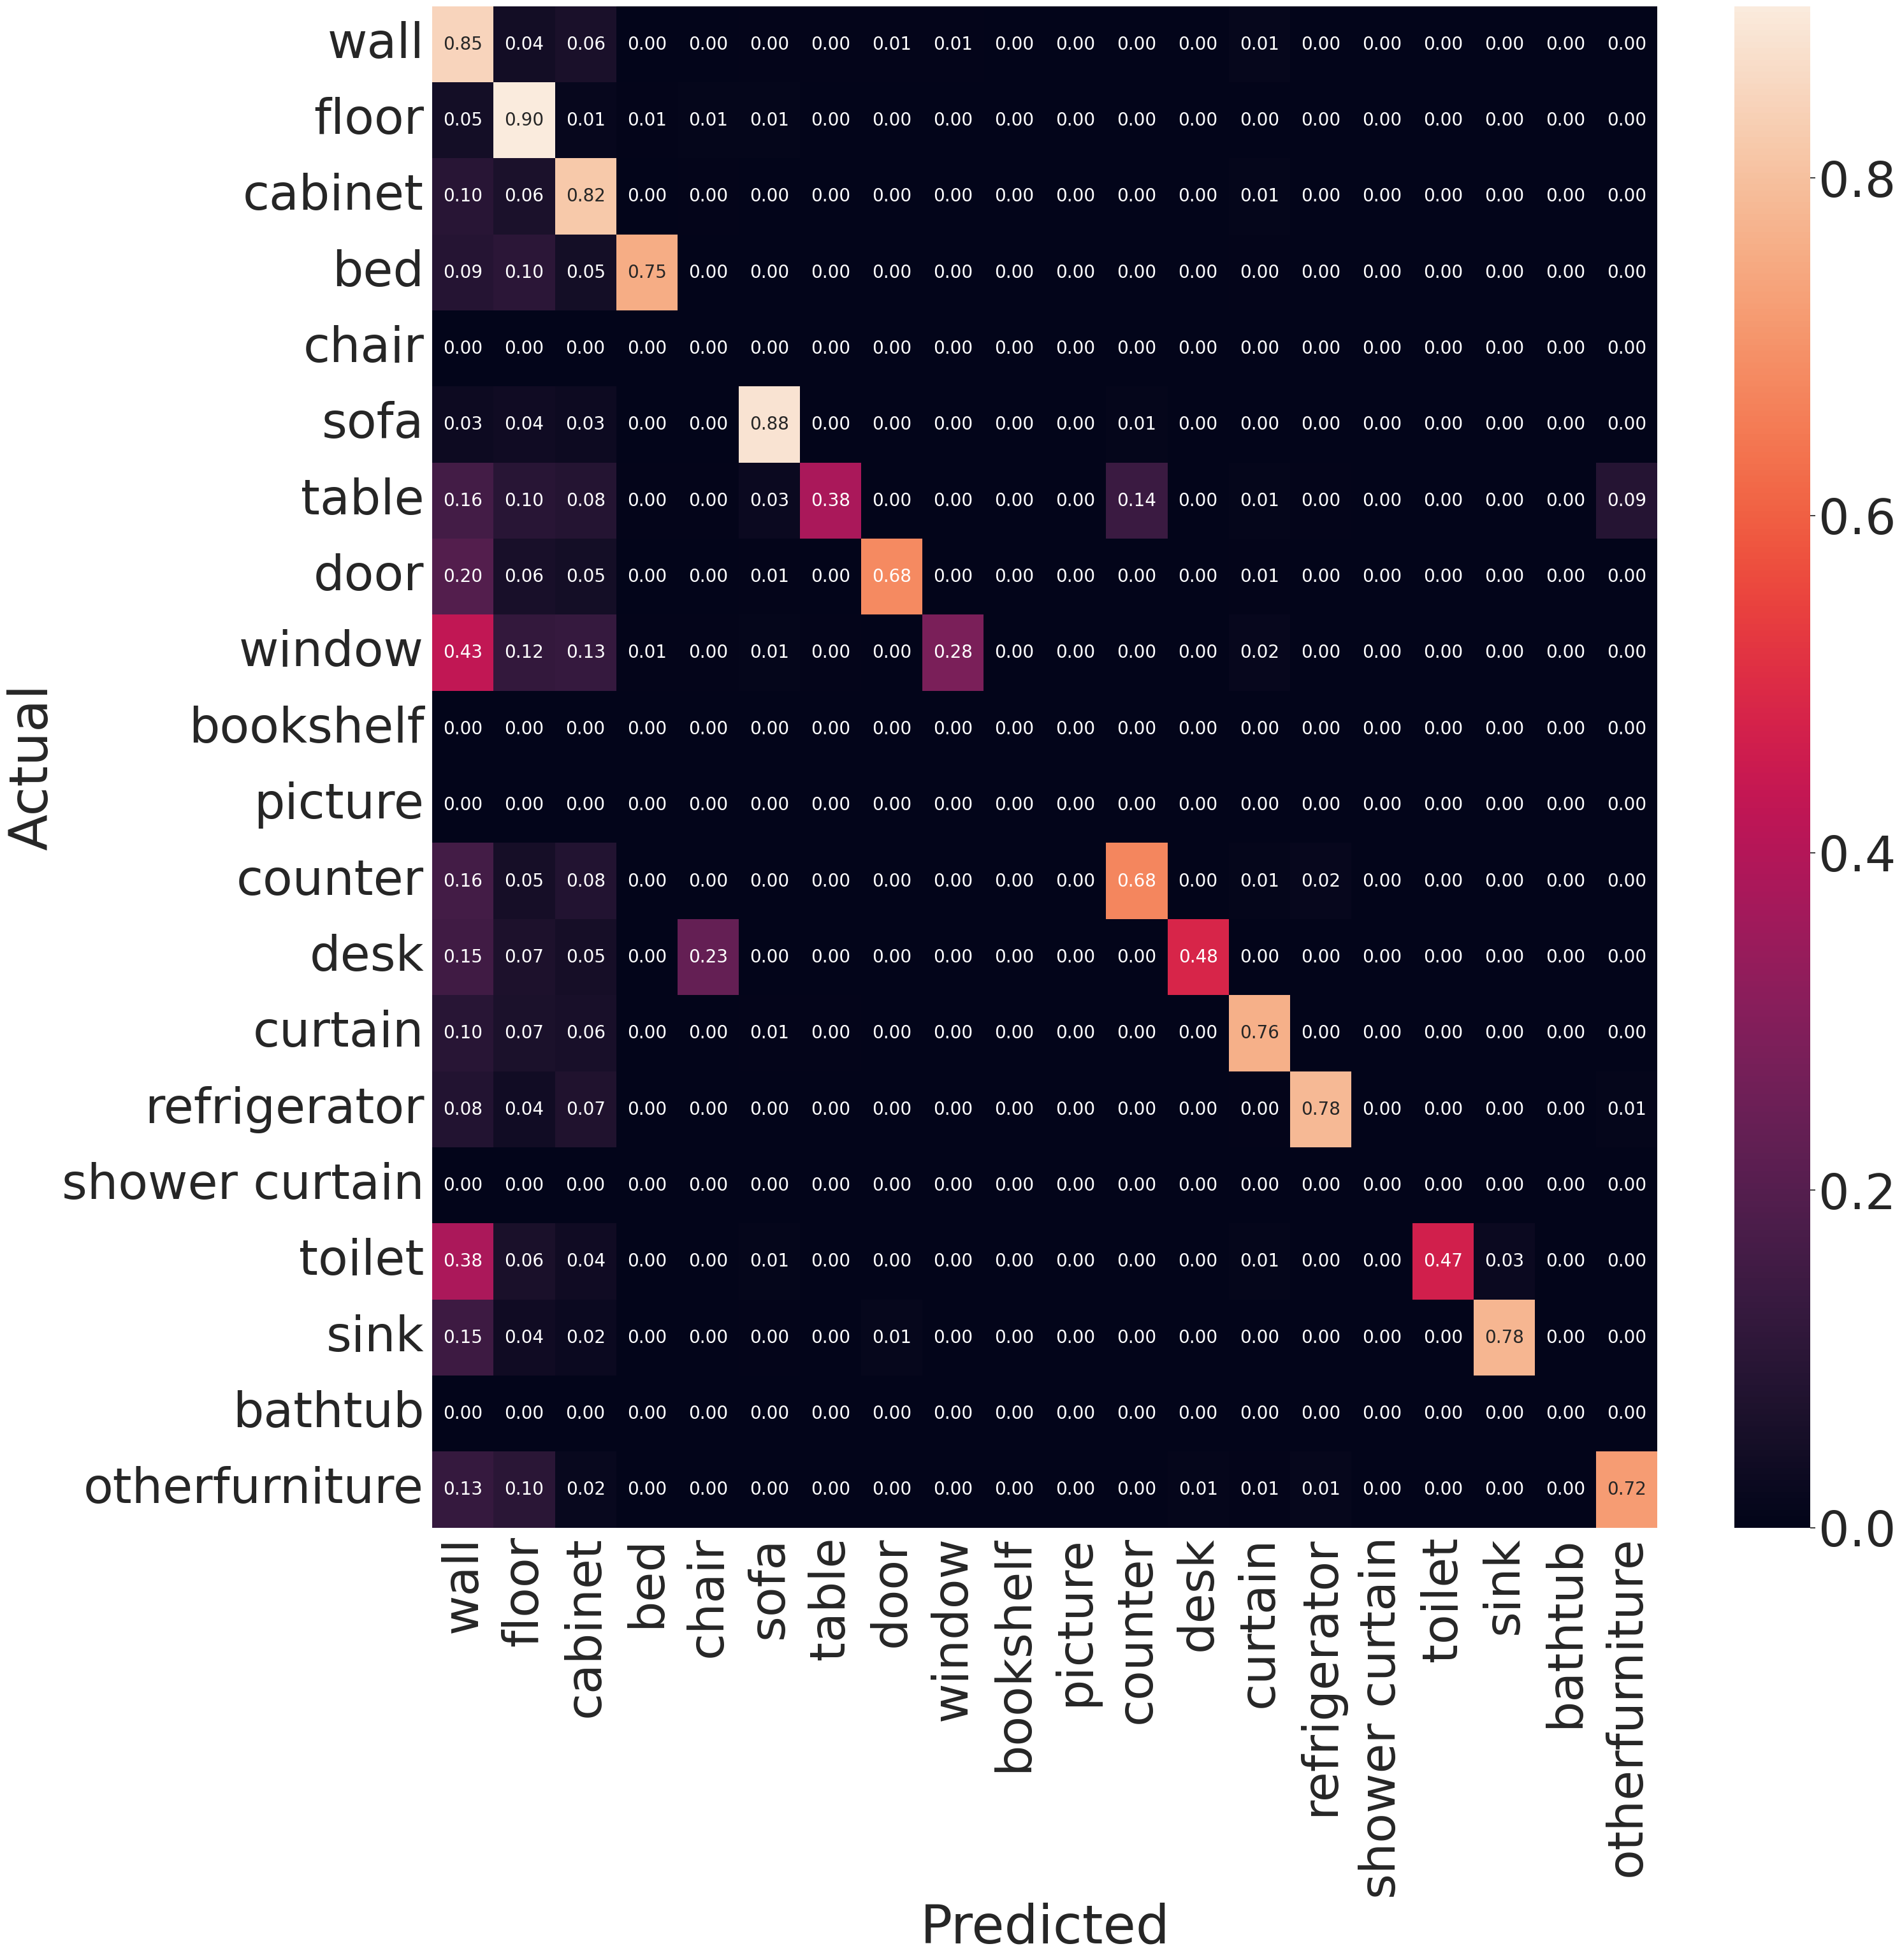

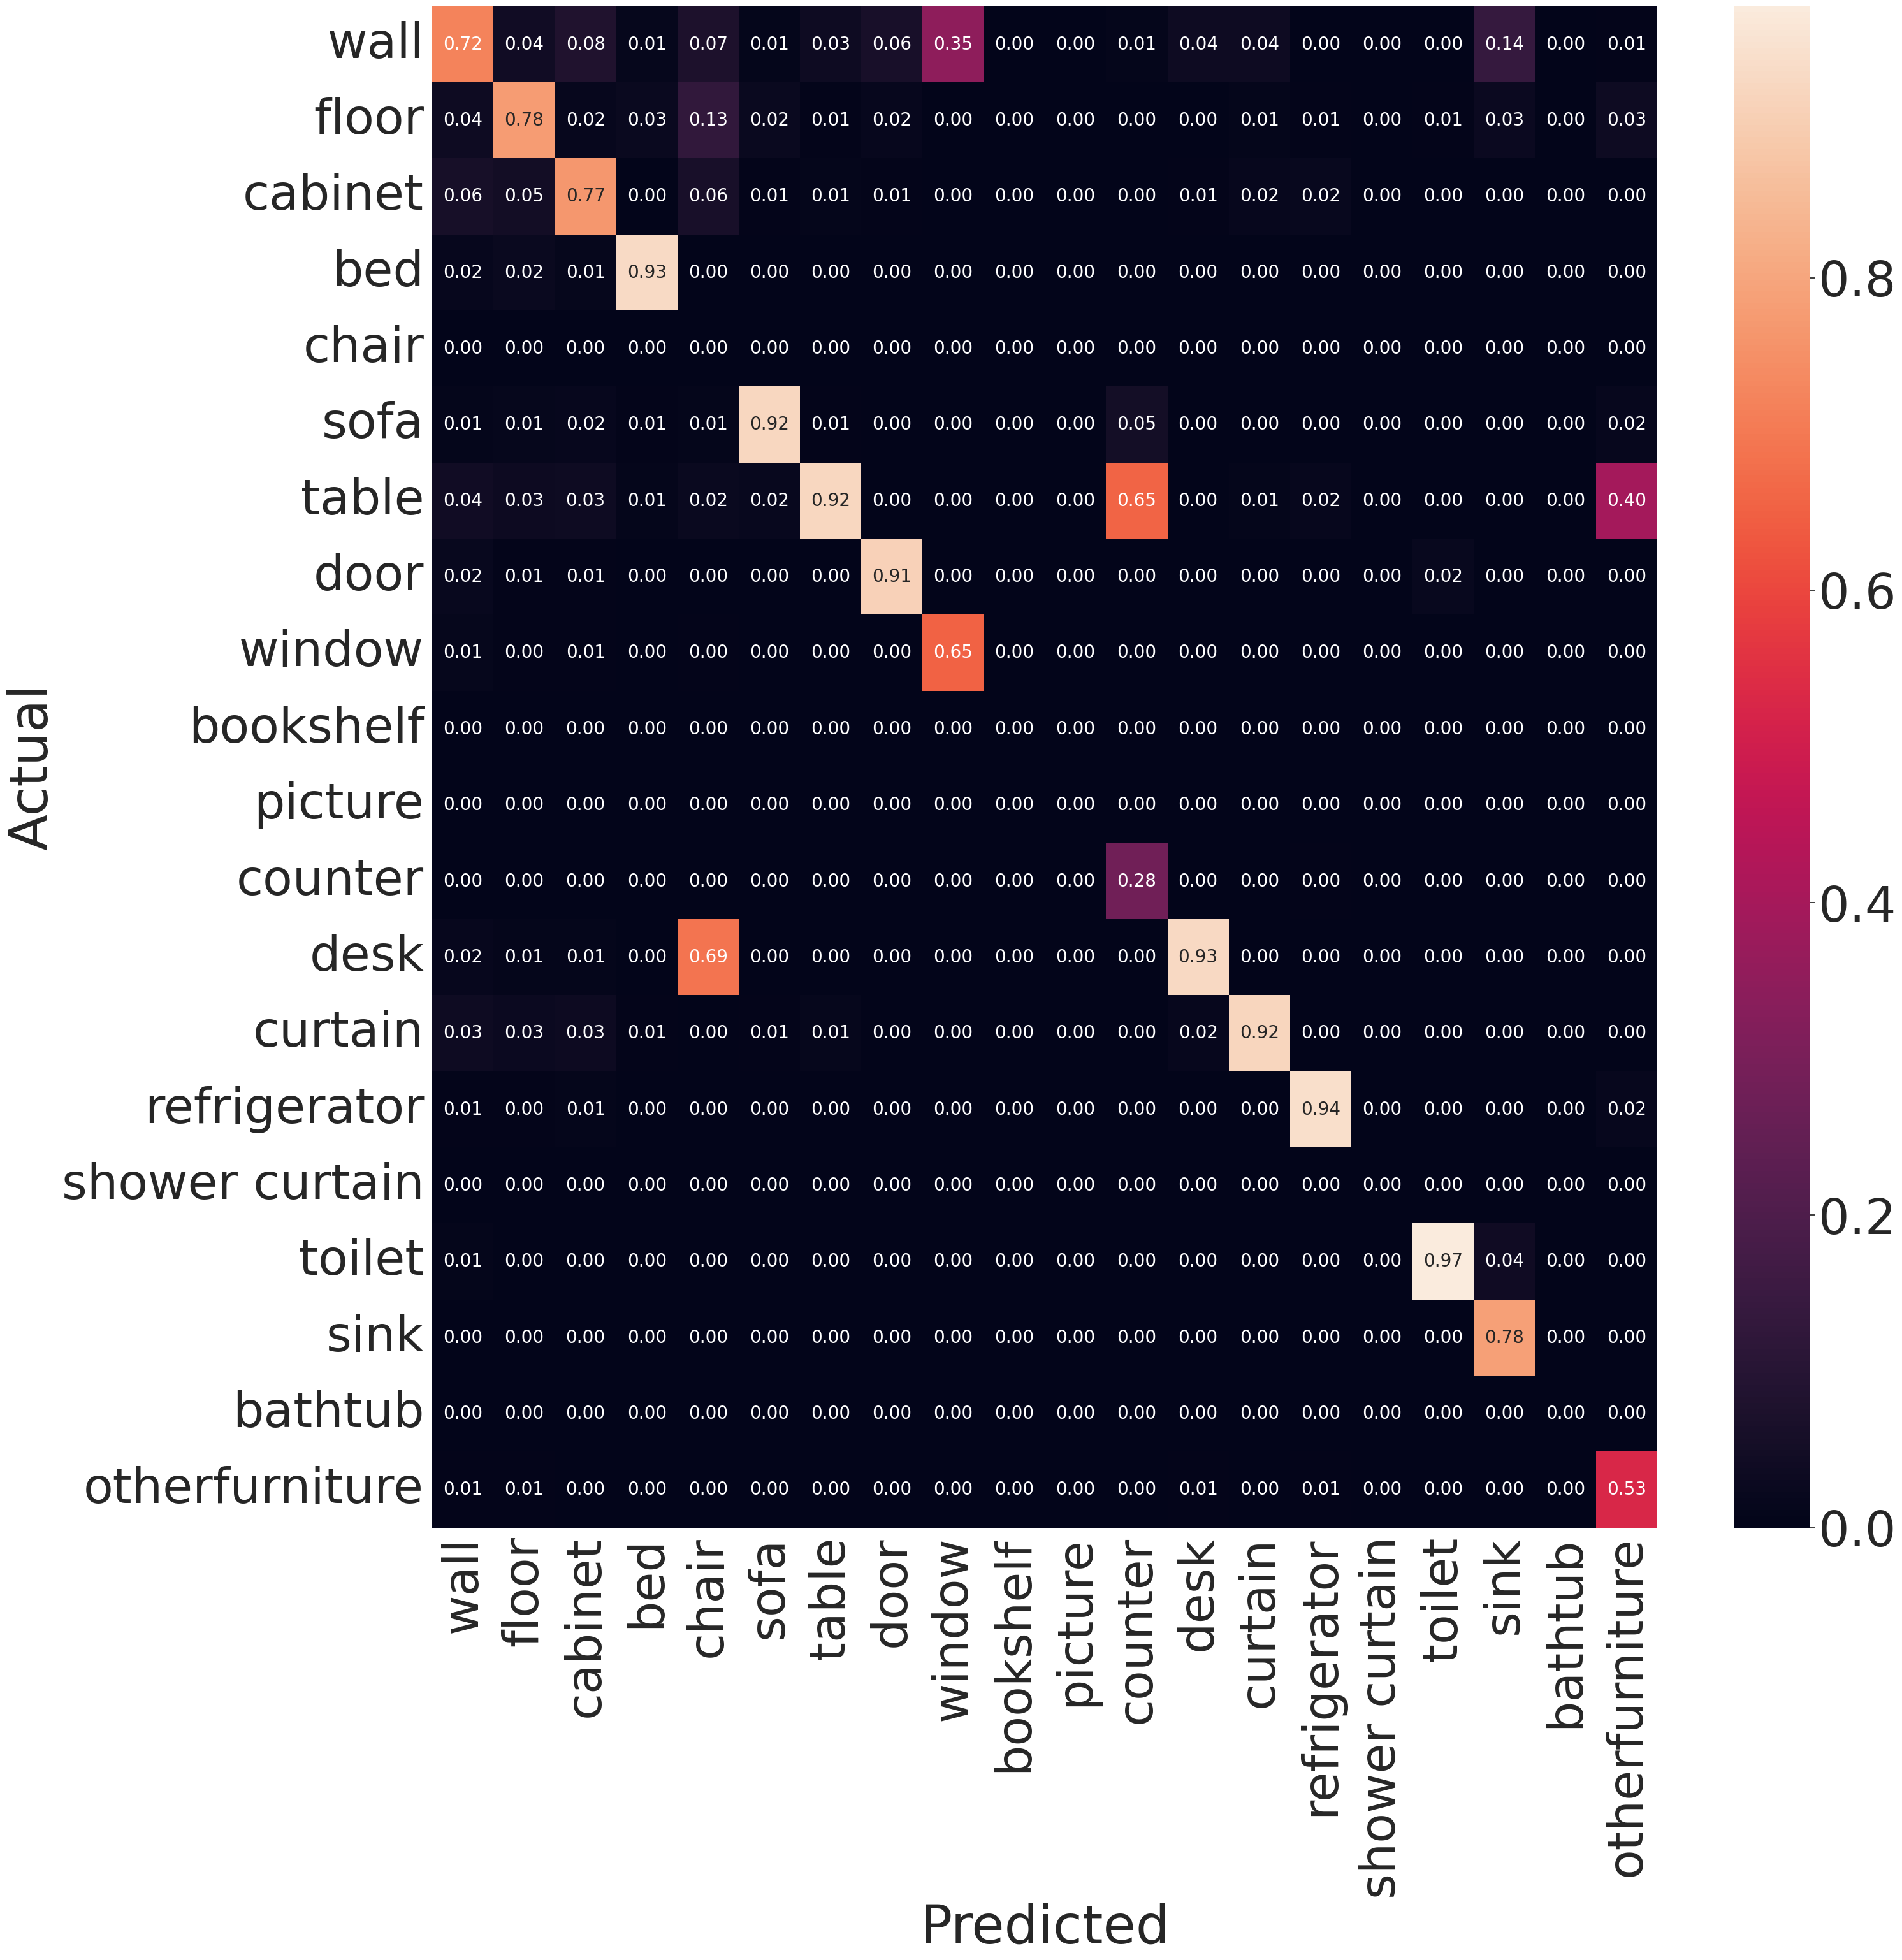

In [32]:
def save_confusion_matrix(cm, path2save=None, ordered_names=None):
    import seaborn as sns
    import matplotlib.pyplot as plt

    sns.set(font_scale=5)
    
#     template_path = os.path.join(path2save, "{}.svg")
    # PRECISION
    cmn = cm.astype("float") / cm.sum(axis=-1)[:, np.newaxis]
    cmn[np.isnan(cmn) | np.isinf(cmn)] = 0
    fig, ax = plt.subplots(figsize=(31, 31))
    sns.heatmap(
        cmn, annot=True, fmt=".2f", xticklabels=ordered_names, yticklabels=ordered_names, annot_kws={"size": 20}
    )
    # g.set_xticklabels(g.get_xticklabels(), rotation = 35, fontsize = 20)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    
#     path_precision = template_path.format("precision")
#     plt.savefig(path_precision, format="svg")

    # RECALL
    cmn = cm.astype("float") / cm.sum(axis=0)[np.newaxis, :]
    cmn[np.isnan(cmn) | np.isinf(cmn)] = 0
    fig, ax = plt.subplots(figsize=(31, 31))
    sns.heatmap(
        cmn, annot=True, fmt=".2f", xticklabels=ordered_names, yticklabels=ordered_names, annot_kws={"size": 20}
    )
    # g.set_xticklabels(g.get_xticklabels(), rotation = 35, fontsize = 20)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()
    
#     path_recall = template_path.format("recall")
    #plt.savefig(path_recall, format="svg")


save_confusion_matrix(tracker._confusion_matrix.confusion_matrix, ordered_names=CLASS_LABELS)

In [15]:
# scene 0000_00
computeScores(data, mode_preds, dataset, stage='train', tracker=None)

{'train_acc': 78.5082992024143,
 'train_macc': 68.44232036545344,
 'train_miou': 53.298953827959814}

{'train_acc': 78.5082992024143,
 'train_macc': 68.44232036545344,
 'train_miou': 53.298953827959814}

In [23]:
# scene0190_0
computeScores(data, mode_preds, dataset, stage='train', tracker=None)\

{'train_acc': 88.12224636669923,
 'train_macc': 66.77507086551887,
 'train_miou': 41.859285338265536}

{'train_acc': 88.12224636669923,
 'train_macc': 66.77507086551887,
 'train_miou': 41.859285338265536}

In [31]:
# scene0190_1
computeScores(data, mode_preds, dataset, stage='train', tracker=None)

{'train_acc': 88.02479415302064,
 'train_macc': 75.62845810740538,
 'train_miou': 46.844401523580046}

{'train_acc': 88.02479415302064,
 'train_macc': 75.62845810740538,
 'train_miou': 46.844401523580046}

# Process MMData to compatible input for MVFusion model

#### Step by step process:
1. ~Take the MMData object from the dataloader~
2. ~Find out how the mappings are stored and accessed. Hint: check 'SelectMappingFromPointId' and 'PickImagesFromMemoryCredit'~
3. Select 9 random views for each 3d point, while maximizing differences between camera positions. I have chosen to not use extrinsics as I hypothesize that there already will be large differences in poses when camera position is different.
4. Get M2F labels for each view
5. Add the missing features to each viewing condition vector
6. Input the prost-processed sample to MVFusion model


Random thoughts:
- Adding noise to viewing conditions 
- 3. has to be vectorized (not for looping through n_points)


In [15]:
# # Step 3
# most_seen_point = dense_idx_list[0].unique(return_counts=True)[1].argmax()

# mm_data = seen_mm_data#[[0, most_seen_point, 1, 2]]
# image_data = mm_data.modalities['image']
# samesetting_data = image_data[0]   # take first in SameSettingImageData since ScanNet only has 1 setting
# print(samesetting_data)

# print(samesetting_data.__dict__.keys())

# # camera positions
# print(samesetting_data.pos)

# print(samesetting_data.mappings)

In [25]:
# how to group each point's views?
print(image_data.view_cat_csr_indexing)
print(samesetting_data.view_csr_indexing)

csr_idx = image_data.view_cat_csr_indexing

# Compute dense indices from CSR indices
n_groups = csr_idx.shape[0] - 1
dense_idx = torch.arange(n_groups).to(csr_idx.device).repeat_interleave(
    csr_idx[1:] - csr_idx[:-1])
# if src.dim() > 1:
#     dense_idx = dense_idx.view(-1, 1).repeat(1, src.shape[1])
    
print(dense_idx)

tensor([     0,      4,      8,  ..., 379406, 379407, 379408])
tensor([     0,      4,      8,  ..., 379406, 379407, 379408])
tensor([    0,     0,     0,  ..., 64885, 64886, 64887])


In [35]:
mm_data.num_points

64888

In [16]:
# import time
# s = time.time()

# def extract_viewing_data_per_point(mm_data):
#     n_views = 9
    
    
#     image_data = mm_data.modalities['image']
#     csr_idx = image_data.view_cat_csr_indexing

    
# #     # Compute dense indices from CSR indices
# #     n_groups = csr_idx.shape[0] - 1
# #     dense_idx = torch.arange(n_groups).to(csr_idx.device).repeat_interleave(
# #         csr_idx[1:] - csr_idx[:-1])
    
# #     print(dense_idx)
    
# #     # batch_idx: to which image a view-condition feature belongs
# #     # CSRData: n/a
# #     # viewing_conditions: feature vector of an image-pixel match
# #     for x in image_data[0].mappings.values:
# #         print(x)
        
#     viewing_conditions = image_data[0].mappings.values[2]
    
#     # Add pixel validity as first feature!
#     viewing_conditions = torch.cat((torch.ones(viewing_conditions.shape[0], 1).to(viewing_conditions.device),
#                                     viewing_conditions), dim=1)
    
    
#     # Calculate amount of empty views. There should be n_points * n_views filled view conditions in total.
#     n_seen = csr_idx[1:] - csr_idx[:-1]
    
#     unfilled_points = n_seen[n_seen < n_views]
#     n_views_to_fill = int(len(unfilled_points) * n_views - sum(unfilled_points))
    
#     random_invalid_views = viewing_conditions[np.random.choice(range(len(viewing_conditions)), size=n_views_to_fill, replace=True)]
#     # set pixel validity to invalid
#     random_invalid_views[:, 0] = 0
    
    
#     # faster method: conccaat viewing conditions and random invalid views, then index the tensor such that each point
#     # either has 9 valid subsampled views, or is filled to 9 views with random views
#     combined_tensor = torch.cat((viewing_conditions, random_invalid_views), dim=0)
    
#     unused_invalid_view_idx = len(viewing_conditions)
#     combined_idx = []
#     for i, n in enumerate(n_seen):
#         if n < n_views:
#             n_empty_views = n_views -  n
#             combined_idx += list(range(csr_idx[i], csr_idx[i+1])) + \
#                             list(range(unused_invalid_view_idx, unused_invalid_view_idx + n_empty_views))
#             unused_invalid_view_idx += n_empty_views
#         elif n > n_views:
#             sampled_idx = sorted(np.random.choice(range(csr_idx[i], csr_idx[i+1]), size=n_views, replace=False))
#             combined_idx += sampled_idx
            
#         else:
#             combined_idx += list(range(csr_idx[i], csr_idx[i+1]))
    
#     combined_tensor = combined_tensor[combined_idx]    
#     return combined_tensor.reshape(mm_data.num_points, n_views, -1)
        
# extract_viewing_data_per_point(mm_data)


In [23]:
### Redundant code

# s = time.time()
# ### view sampling per point
# view_data_per_point, random_invalid_views = extract_viewing_data_per_point(mm_data)

# cum_sampled_views = 0
# for i in range(len(view_data_per_point)):
#     if len(view_data_per_point[i]) > 9:
#         sampled_idx = sorted(np.random.choice(range(len(view_data_per_point[i])), size=9, replace=False))
#         view_data_per_point[i] = view_data_per_point[i][sampled_idx]
#     else:
#         # Each point should have 9 views, so fill points with random invalid view conditions till it contains 9 views
#         n_views = len(view_data_per_point[i])
#         n_empty = 9 - n_views
#         view_data_per_point[i] = torch.cat((view_data_per_point[i], 
#                                             random_invalid_views[cum_sampled_views:cum_sampled_views+n_empty]), dim=0)
#         cum_sampled_views += n_empty
                
# print(time.time() - s)

# # view_data_per_point


1.5583267211914062


In [12]:

# idx mapping from each pixel to point
im_data = test_data.modalities['image']    # need SameSettingImageData object so no [0] slicing

dense_idx_list = [
            torch.arange(im.num_points, device=im_data.device).repeat_interleave(
                im.view_csr_indexing[1:] - im.view_csr_indexing[:-1])
            for im in im_data]
dense_idx_list[0]

tensor([0, 0, 1, 1])

### Trying to point-image & point-pixel mappings

In [120]:
mapping = mm_data.modalities['image'][0].mappings
mapping

ImageMapping(num_groups=81369, num_items=81821, device=cpu)

In [122]:
mapping.__dict__
# pointers: csr_idx, aka which tensors belong to the same view
# values[0]: indicates the image idx
# values[1]: CSRData holding pixel indices, called with values[1].values[0]

{'pointers': tensor([    0,     0,     0,  ..., 81821, 81821, 81821]),
 'values': [tensor([ 9,  9,  9,  ..., 13,  4, 18]),
  CSRData(num_groups=81821, num_items=81821, device=cpu),
  tensor([[0.3528, 0.2270, 0.6533,  ..., 0.4220, 0.0727, 0.8235],
          [0.3552, 0.1550, 0.5808,  ..., 0.3821, 0.0875, 0.4314],
          [0.3505, 0.0111, 0.6325,  ..., 0.3873, 0.0810, 0.3922],
          ...,
          [0.4889, 0.2754, 0.6022,  ..., 0.1002, 0.0594, 0.4314],
          [0.3923, 0.0640, 0.7785,  ..., 0.0044, 0.0873, 0.0980],
          [0.4105, 0.4782, 0.3603,  ..., 0.0367, 0.0568, 0.2157]])],
 'is_index_value': tensor([ True, False, False])}

In [126]:
# Image idx of each point-pixel match
idx_batch = mapping.values[0].repeat_interleave(
    mapping.values[1].pointers[1:] - mapping.values[1].pointers[:-1])
idx_batch

tensor([ 9,  9,  9,  ..., 13,  4, 18])

In [72]:
# idx mapping from each pixel to point
im_data = mm_data.modalities['image']

dense_idx_list = [
            torch.arange(im.num_points, device=im_data.device).repeat_interleave(
                im.view_csr_indexing[1:] - im.view_csr_indexing[:-1])
            for im in im_data]
dense_idx_list[0]

NameError: name 'mm_data' is not defined

In [135]:
dense_idx_list[0].unique(return_counts=True)[1].min()

tensor(1)

In [125]:
mm_data.modalities['image'].get_mapped_features(interpolate=False)

def get_mapped_features(mod_data, interpolate=False):
    """Return the mapped features, with optional interpolation. If
    `interpolate=False`, the mappings will be adjusted to
    `self.img_size`: the current size of the feature map `self.x`.
    """
    # Compute the feature map's sampling ratio between the input
    # `mapping_size` and the current `img_size`
    # TODO: treat scales independently. Careful with min or max
    #  depending on upscale and downscale
    scale = 1 / mod_data.downscale

    # If not interpolating, set the mapping to the proper scale
    mappings = mod_data.mappings if interpolate \
        else mod_data.mappings.rescale_images(scale)

    # Index the features with/without interpolation
    if interpolate and scale != 1:
        print("BAAAKA")
        resolution = torch.Tensor([mod_data.mapping_size]).to(mod_data.device)
        coords = mappings.pixels / (resolution - 1)
        coords = coords[:, [1, 0]]  # pixel mappings are in (W, H) format
        batch = mappings.feature_map_indexing[0]
        x = sparse_interpolation(mod_data.x, coords, batch)
    else:
        x = mod_data.x[mappings.feature_map_indexing]

    return x
    
get_mapped_features(mm_data.modalities['image'][0], interpolate=True)

#### Returns indices for extracting mapped data from a batch of image feature maps

In [11]:
im = mm_data.modalities['image'][0]
print(im.feature_map_indexing)

im = mm_data.modalities['image']
print(im.feature_map_indexing)


(tensor([22, 22, 22,  ...,  2,  2, 10]), Ellipsis, tensor([72, 75, 74,  ...,  3,  2,  8]), tensor([216, 215, 212,  ...,  12,   9, 300]))
[(tensor([22, 22, 22,  ...,  2,  2, 10]), Ellipsis, tensor([72, 75, 74,  ...,  3,  2,  8]), tensor([216, 215, 212,  ...,  12,   9, 300]))]


In [ ]:
#################### I found out how indices are stored. 
#################### Now, check out how the ImageMapping is calculated! in MapImages transform


def feature_map_indexing(SameSettingImageData):  # function within ImageMapping object
    """Return the indices for extracting mapped data from the
    corresponding batch of image feature maps.

    The batch of image feature maps X is expected to have the shape
    `[B, C, H, W]`. The returned indexing object idx is intended to
    be used for recovering the mapped features as: `X[idx]`.
    """
    mappings = SameSettingImageData.mappings
    
    print(mappings.features[:10])
    
    idx_batch = mappings.images.repeat_interleave(
        mappings.values[1].pointers[1:] - mappings.values[1].pointers[:-1])
    idx_height = mappings.pixels[:, 1]
    idx_width = mappings.pixels[:, 0]
    idx = (idx_batch.long(), ..., idx_height.long(), idx_width.long())
    return idx

im = mm_data.modalities['image'][0]   # SameSettingImageData
feature_map_indexing(im)

mm_data.data.__dict__

In [27]:
images = seen_mm_data.modalities['image']
n_seen = sum([
            im.mappings.pointers[1:] - im.mappings.pointers[:-1]
            for im in images])
n_seen.argmax()   # by how many views a 3d point is seen

tensor(26556)

In [21]:
# Compute the unseen points boolean masks and split them in a
# list of masks for easier popping

# if self.use_coverage:
def PickImages(data, images):
    """
    Returns how many points each view sees
    """
    img_unseen_points = torch.zeros(
        images.num_views, data.num_nodes, dtype=torch.bool)
    i_offset = 0
    for im in images:
        mappings = im.mappings
        i_idx = mappings.images + i_offset
        j_idx = mappings.points.repeat_interleave(
            mappings.pointers[1:] - mappings.pointers[:-1])
        img_unseen_points[i_idx, j_idx] = True
        i_offset += im.num_views
    img_unseen_points = [x.numpy() for x in img_unseen_points]
    
    print([img_unseen_points[x].sum() for x in range(len(img_unseen_points))])
    
PickImages(seen_mm_data.data, seen_mm_data.modalities['image'])

[3803, 4053, 4472, 3447, 4429, 3796, 3490, 3764, 4196, 3650, 3520, 2221, 3775, 3414, 3240, 3109, 3219, 3967, 3825, 3156, 5118, 2617, 3521, 4046, 2274]


## Run inference from pretrained weights and visualize predictions
It is possible to visualize the pointwise predictions and errors from a model. 

To do so, we will use the pretrained weights made available with this project. See `README.md` to get the download links and manually place the `.pt` files locally. You will need to provide `checkpoint_dir` where you saved those files in the next cell.

In [ ]:
from torch_points3d.models.model_factory import instantiate_model

# Set your parameters
checkpoint_dir = '/home/fsun/DeepViewAgg/model_checkpoints'

# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)
# print(model)

# Load the checkpoint and recover the 'latest' model weights
checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
model.load_state_dict_with_same_shape(checkpoint['models']['latest'], strict=False)

# Prepare the model for inference
model = model.eval().cuda()
print('Model loaded')

Now we have loaded the model, we need to run a forward pass on a sample. Howver, if we want to be able to visualize the predictions, we need to pay special attention to which type of 3D and 2D transforms we apply on the data if we do not want to break the mappings. To do so, we will manually apply some sensitive transforms to be able to both infer on the data and visualize it.

In [ ]:
i_room = 3

# Pick a room in the Train set
mm_data = sample_real_data(dataset.train_dataset, idx=i_room, exclude_3d=exclude_3d_viz, exclude_2d=exclude_2d_viz)

# Pick a room in the Val set
# mm_data = sample_real_data(dataset.val_dataset, idx=i_room, exclude_3d=exclude_3d_viz, exclude_2d=exclude_2d_viz)

# Pick a room in the Test set
# mm_data = sample_real_data(dataset.test_dataset[0], idx=i_room, exclude_3d=exclude_3d_viz, exclude_2d=exclude_2d_viz)

# Extract point cloud and images from MMData object
data = mm_data.data.clone()
images = mm_data.modalities['image'].clone()

# For voxel-based 3D backbones such as SparseConv3d and MinkowskiNet, points need to be 
# preprocessed with Center and GridSampling3D. Unfortunately, Center breaks relative 
# positions between points and images. Besides, the combination of Center and GridSampling3D
# may lead to some points being merged into the same voxels, so we must apply it to both the
# inference and visualization data to make sure we have the same voxels. The workaround here 
# is to manually run these while keeping track of the centering offset
center = data.pos.mean(dim=-2, keepdim=True)
data = AddFeatsByKeys(list_add_to_x=[True], feat_names=['pos_z'], delete_feats=[True])(data)          # add z-height to the features
data = Center()(data)                                                                                 # mean-center the data
data = GridSampling3D(cfg.data.resolution_3d, quantize_coords=True, mode='last')(data)                # quantization for volumetric models

# This last voxelization step with GridSampling3D might have removed some points, so we need
# to update the mappings usign SelectMappingFromPointId. To control the size of the batch, we
# use PickImagesFromMemoryCredit. Besides, 2D models expect normalized float images, which is
# why we call ToFloatImage and Normalize
data, images = SelectMappingFromPointId()(data, images)                                               # update mappings after GridSampling3D
data, images = PickImagesFromMemoryCredit(
    img_size=cfg.data.resolution_2d, 
    k_coverage=cfg.data.multimodal.settings.k_coverage, 
    n_img=cfg.data.multimodal.settings.test_pixel_credit)(data, images)                                      # select images to respect memory constraints
data, images_infer = ToFloatImage()(data, images.clone())                                             # convert uint8 images to float
data, images_infer = Normalize()(data, images_infer)                                                  # RGB normalization

# Create a MMData for inference
mm_data_infer = MMData(data, image=images_infer)

# Create a MMBatch and run inference
batch = MMBatch.from_mm_data_list([mm_data_infer])
model.set_input(batch, model.device)
model(batch)

# Create a MMData for visualization
data.pos += center
mm_data = MMData(data, image=images)

# Recover the predicted labels for visualization
mm_data.data.pred = model.output.detach().cpu().argmax(1)

In [ ]:
visualize_mm_data(mm_data, figsize=1000, pointsize=3, voxel=0.05, show_2d=True, front='y', class_names=CLASS_NAMES, class_colors=CLASS_COLORS, alpha=0.3)